## Analyzing players ratings through soccer database

#### This is a regression problem as target variable (players ratings) is a continuous variable.

In [1]:
import sqlite3
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Create your connection to soccer database
cnx = sqlite3.connect('database.sqlite')
# create a dataframe using table Player_Attributes of soccer database
df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)

In [3]:
# view header of dataframe
df.head()

id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00            67.0   
1   2              218353         505942  2015-11-19 00:00:00            67.0   
2   3              218353         505942  2015-09-21 00:00:00            62.0   
3   4              218353         505942  2015-03-20 00:00:00            61.0   
4   5              218353         505942  2007-02-22 00:00:00            61.0   

   potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0       71.0          right              medium              medium      49.0   
1       71.0          right              medium              medium      49.0   
2       66.0          right              medium              medium      49.0   
3       65.0          right              medium              medium      48.0   
4       65.0          right              medium              medium      48.0   

      ...       vision  penalties  marking  standing_tackle  sliding_tackle  \
0     ...         54.0       48.0     65.0             69.0            69.0   
1     ...         54.0       48.0     65.0             69.0            69.0   
2     ...         54.0       48.0     65.0             66.0            69.0   
3     ...         53.0       47.0     62.0             63.0            66.0   
4     ...         53.0       47.0     62.0             63.0            66.0   

   gk_diving  gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0        6.0         11.0        10.0             8.0          8.0  
1        6.0         11.0        10.0             8.0          8.0  
2        6.0         11.0        10.0             8.0          8.0  
3        5.0         10.0         9.0             7.0          7.0  
4        5.0         10.0         9.0             7.0          7.0  

[5 rows x 42 columns]

In [4]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [5]:
# view summary of dataframe
df.describe()

id  player_fifa_api_id  player_api_id  overall_rating  \
count  183978.00000       183978.000000  183978.000000   183142.000000   
mean    91989.50000       165671.524291  135900.617324       68.600015   
std     53110.01825        53851.094769  136927.840510        7.041139   
min         1.00000            2.000000    2625.000000       33.000000   
25%     45995.25000       155798.000000   34763.000000       64.000000   
50%     91989.50000       183488.000000   77741.000000       69.000000   
75%    137983.75000       199848.000000  191080.000000       73.000000   
max    183978.00000       234141.000000  750584.000000       94.000000   

           potential       crossing      finishing  heading_accuracy  \
count  183142.000000  183142.000000  183142.000000     183142.000000   
mean       73.460353      55.086883      49.921078         57.266023   
std         6.592271      17.242135      19.038705         16.488905   
min        39.000000       1.000000       1.000000          1.000000   
25%        69.000000      45.000000      34.000000         49.000000   
50%        74.000000      59.000000      53.000000         60.000000   
75%        78.000000      68.000000      65.000000         68.000000   
max        97.000000      95.000000      97.000000         98.000000   

       short_passing        volleys      ...               vision  \
count  183142.000000  181265.000000      ...        181265.000000   
mean       62.429672      49.468436      ...            57.873550   
std        14.194068      18.256618      ...            15.144086   
min         3.000000       1.000000      ...             1.000000   
25%        57.000000      35.000000      ...            49.000000   
50%        65.000000      52.000000      ...            60.000000   
75%        72.000000      64.000000      ...            69.000000   
max        97.000000      93.000000      ...            97.000000   

           penalties        marking  standing_tackle  sliding_tackle  \
count  183142.000000  183142.000000    183142.000000   181265.000000   
mean       55.003986      46.772242        50.351257       48.001462   
std        15.546519      21.227667        21.483706       21.598778   
min         2.000000       1.000000         1.000000        2.000000   
25%        45.000000      25.000000        29.000000       25.000000   
50%        57.000000      50.000000        56.000000       53.000000   
75%        67.000000      66.000000        69.000000       67.000000   
max        96.000000      96.000000        95.000000       95.000000   

           gk_diving    gk_handling     gk_kicking  gk_positioning  \
count  183142.000000  183142.000000  183142.000000   183142.000000   
mean       14.704393      16.063612      20.998362       16.132154   
std        16.865467      15.867382      21.452980       16.099175   
min         1.000000       1.000000       1.000000        1.000000   
25%         7.000000       8.000000       8.000000        8.000000   
50%        10.000000      11.000000      12.000000       11.000000   
75%        13.000000      15.000000      15.000000       15.000000   
max        94.000000      93.000000      97.000000       96.000000   

         gk_reflexes  
count  183142.000000  
mean       16.441439  
std        17.198155  
min         1.000000  
25%         8.000000  
50%        11.000000  
75%        15.000000  
max        96.000000  

[8 rows x 38 columns]

In [6]:
# view shape of data frame
df.shape
print(f"shape of the DataFrame is : {df.shape}")
print(f"Rows : {df.shape[0]} \nColumns : {df.shape[1]}")

shape of the DataFrame is : (183978, 42)
Rows : 183978 
Columns : 42


In [7]:
# print column names in readable format
[(f"column {i+1} : {column}") for i,column in enumerate(df.columns)]

['column 1 : id',
 'column 2 : player_fifa_api_id',
 'column 3 : player_api_id',
 'column 4 : date',
 'column 5 : overall_rating',
 'column 6 : potential',
 'column 7 : preferred_foot',
 'column 8 : attacking_work_rate',
 'column 9 : defensive_work_rate',
 'column 10 : crossing',
 'column 11 : finishing',
 'column 12 : heading_accuracy',
 'column 13 : short_passing',
 'column 14 : volleys',
 'column 15 : dribbling',
 'column 16 : curve',
 'column 17 : free_kick_accuracy',
 'column 18 : long_passing',
 'column 19 : ball_control',
 'column 20 : acceleration',
 'column 21 : sprint_speed',
 'column 22 : agility',
 'column 23 : reactions',
 'column 24 : balance',
 'column 25 : shot_power',
 'column 26 : jumping',
 'column 27 : stamina',
 'column 28 : strength',
 'column 29 : long_shots',
 'column 30 : aggression',
 'column 31 : interceptions',
 'column 32 : positioning',
 'column 33 : vision',
 'column 34 : penalties',
 'column 35 : marking',
 'column 36 : standing_tackle',
 'column 37 : sl

## Data Preprocessing

In [8]:
#Create a new dataframe after dropping some columns which are not useful to predict player overall ratings
soccer_data = df.drop(["id", "player_fifa_api_id", "player_api_id", "date"], axis = 1)

#Check whether there are duplicates entries present or not
soccer_data.duplicated().any()

True

In [9]:
#Drop duplicates entries from soccer_data dataframe
soccer_data.drop_duplicates(inplace=True)

#check dataframe shape after dropping duplicate entries
soccer_data.shape

(138440, 38)

In [10]:
#check number of missing parameters in the DataFrame - Columnwise
soccer_data.isnull().values.sum()

12216

In [11]:
# functions to handle missing data
def data_preprocessing(df):
    df.convert_objects(convert_numeric=True)
    df.fillna(-99999, inplace=True)     
    return df

#call function to hanbdle missing data
data_preprocessing(soccer_data)

#check number of missing parameters in the DataFrame - Columnwise after handling missing data (should be 0)
soccer_data.isnull().values.sum()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


0

In [12]:
soccer_data = pd.get_dummies(soccer_data)
soccer_data.head(1)

overall_rating  potential  crossing  finishing  heading_accuracy  \
0            67.0       71.0      49.0       44.0              71.0   

   short_passing  volleys  dribbling  curve  free_kick_accuracy  \
0           61.0     44.0       51.0   45.0                39.0   

             ...              defensive_work_rate_9  defensive_work_rate__0  \
0            ...                                  0                       0   

   defensive_work_rate_ean  defensive_work_rate_es  defensive_work_rate_high  \
0                        0                       0                         0   

   defensive_work_rate_low  defensive_work_rate_medium  defensive_work_rate_o  \
0                        0                           1                      0   

   defensive_work_rate_ormal  defensive_work_rate_tocky  
0                          0                          0  

[1 rows x 67 columns]

In [13]:
# view shape of data frame
soccer_data.shape
print(f"shape of the DataFrame after one hot encoding is : {soccer_data.shape}")

shape of the DataFrame after one hot encoding is : (138440, 67)


In [14]:
soccer_data.describe()

overall_rating      potential       crossing      finishing  \
count   138440.000000  138440.000000  138440.000000  138440.000000   
mean        68.572233      73.274061      54.801914      49.471641   
std        269.033885     269.038823     269.475747     269.585690   
min     -99999.000000  -99999.000000  -99999.000000  -99999.000000   
25%         65.000000      69.000000      46.000000      34.000000   
50%         69.000000      74.000000      60.000000      53.000000   
75%         74.000000      78.000000      68.000000      66.000000   
max         94.000000      97.000000      95.000000      97.000000   

       heading_accuracy  short_passing        volleys      dribbling  \
count     138440.000000  138440.000000  138440.000000  138440.000000   
mean          57.050195      62.239367   -1021.132274      58.760712   
std          269.438570     269.309300   10296.052731     269.519877   
min       -99999.000000  -99999.000000  -99999.000000  -99999.000000   
25%           50.000000      58.000000      35.000000      52.000000   
50%           60.000000      66.000000      53.000000      64.000000   
75%           69.000000      72.000000      64.000000      72.000000   
max           98.000000      97.000000      93.000000      97.000000   

               curve  free_kick_accuracy            ...              \
count  138440.000000       138440.000000            ...               
mean    -1017.740393           49.060488            ...               
std     10296.405470          269.500618            ...               
min    -99999.000000       -99999.000000            ...               
25%        41.000000           37.000000            ...               
50%        56.000000           51.000000            ...               
75%        67.000000           64.000000            ...               
max        94.000000           97.000000            ...               

       defensive_work_rate_9  defensive_work_rate__0  defensive_work_rate_ean  \
count          138440.000000           138440.000000            138440.000000   
mean                0.000845                0.013081                 0.000621   
std                 0.029059                0.113624                 0.024916   
min                 0.000000                0.000000                 0.000000   
25%                 0.000000                0.000000                 0.000000   
50%                 0.000000                0.000000                 0.000000   
75%                 0.000000                0.000000                 0.000000   
max                 1.000000                1.000000                 1.000000   

       defensive_work_rate_es  defensive_work_rate_high  \
count           138440.000000             138440.000000   
mean                 0.000730                  0.154226   
std                  0.027001                  0.361166   
min                  0.000000                  0.000000   
25%                  0.000000                  0.000000   
50%                  0.000000                  0.000000   
75%                  0.000000                  0.000000   
max                  1.000000                  1.000000   

       defensive_work_rate_low  defensive_work_rate_medium  \
count            138440.000000               138440.000000   
mean                  0.099191                    0.707563   
std                   0.298919                    0.454884   
min                   0.000000                    0.000000   
25%                   0.000000                    0.000000   
50%                   0.000000                    1.000000   
75%                   0.000000                    1.000000   
max                   1.000000                    1.000000   

       defensive_work_rate_o  defensive_work_rate_ormal  \
count          138440.000000              138440.000000   
mean                0.009715                   0.002124   
std                 0.098087                   0.046034   
min                 0.000000  

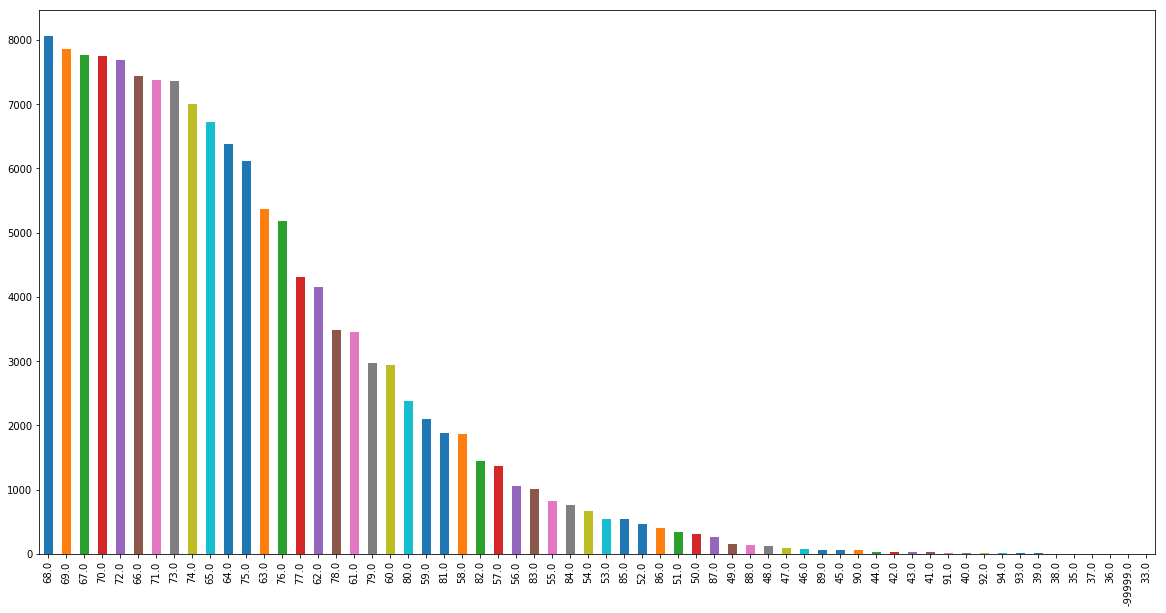

In [15]:
#Visualize column overall_rating of the dataframe
soccer_data['overall_rating'].value_counts()

soccer_data['overall_rating'].value_counts().plot(kind='bar',figsize=(20,10))

In [16]:
#Split dataframe into df_x and df_y
df_x = soccer_data.drop(['overall_rating'], 1)
df_y = np.array(soccer_data['overall_rating'])

In [17]:
#Use RandomForestRegressor to check feature_importances
rfc_1 = RandomForestRegressor(random_state=10)
rfc_1.fit(df_x, df_y)

feature_importances = pd.DataFrame({'feature':df_x.columns,'importance':np.round(rfc_1.feature_importances_,4)})
feature_importances = feature_importances.sort_values('importance',ascending=False).set_index('feature')

In [18]:
print(feature_importances[:35])

                        importance
feature                           
gk_kicking                  0.2001
ball_control                0.1055
positioning                 0.1012
crossing                    0.1008
dribbling                   0.1007
strength                    0.1006
long_passing                0.1003
penalties                   0.1002
reactions                   0.0480
potential                   0.0244
standing_tackle             0.0044
gk_diving                   0.0025
heading_accuracy            0.0018
gk_positioning              0.0014
marking                     0.0011
shot_power                  0.0007
interceptions               0.0007
finishing                   0.0007
gk_handling                 0.0006
stamina                     0.0005
short_passing               0.0005
aggression                  0.0004
sliding_tackle              0.0003
gk_reflexes                 0.0003
sprint_speed                0.0003
acceleration                0.0003
long_shots          

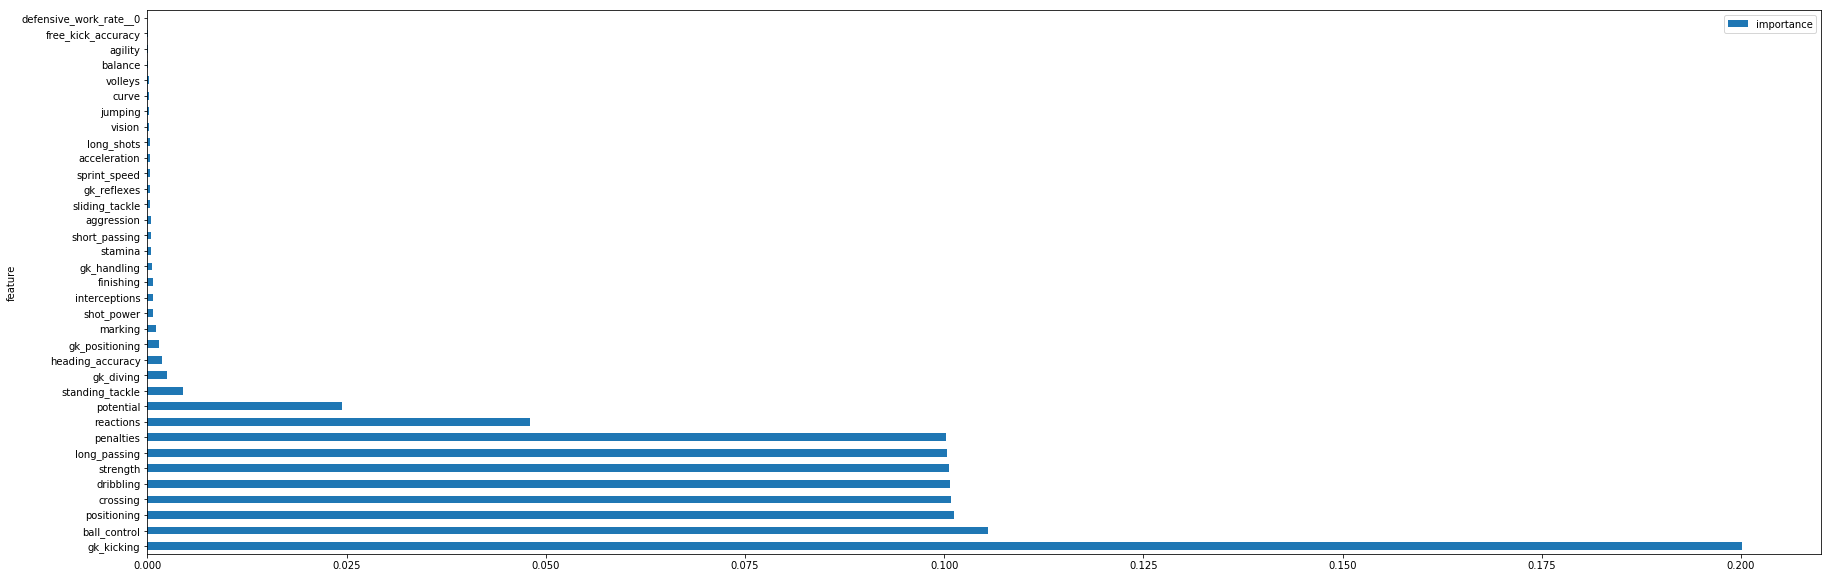

In [19]:
#Visualize top 35 features of the dataframe
feature_importances[:35].plot(kind='barh',figsize=(30,10))

Since features more than 35 are not so important so we will consider only 35 features for further preprocessing of the data 

### Create dataset for train, test and cross-validation

In [20]:
x, x_test, y, y_test = train_test_split(df_x,df_y,test_size=0.2,train_size=0.8, random_state = 55)
x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size = 0.20,train_size =0.80, random_state = 55)

#### Apply scaling on dataframe df_x

In [37]:
from sklearn.preprocessing import StandardScaler, Normalizer, scale
df_x1 = scale(x_train)

#### Perfrom PCA (dimensionality reduction technique) on scaled dataframe

In [38]:
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score
# on non-standardized data

pca = PCA(n_components=10).fit(x_train)

#df_x1 = PCA(n_components=10).fit_transform(df_x)

In [39]:
pca.explained_variance_ratio_

array([9.95931236e-01, 4.05907903e-03, 4.00807495e-06, 2.66323964e-06,
       4.99954698e-07, 4.50403162e-07, 3.10802322e-07, 1.59321111e-07,
       1.46794421e-07, 1.34106743e-07])

In [40]:
from sklearn.decomposition import PCA

# on non-standardized data
df_x2 = pca.transform(x_train)

#### Map test and cross-validation data using pca

In [41]:
pca.transform(x_test)

array([[-2.87192060e+03, -1.92067190e+01,  3.89076836e+01, ...,
         6.13704816e+00, -1.04159976e+01, -6.00107550e+00],
       [-2.89619899e+03, -6.34315217e+01,  5.30239844e+01, ...,
         1.32637625e+00,  1.37421077e+00,  5.55297997e+00],
       [-2.87306907e+03, -3.17066450e+01,  4.70829205e+00, ...,
         8.89786177e+00,  2.14156636e+01, -8.19570848e+00],
       ...,
       [-2.83820880e+03,  1.44159285e+01,  4.12943665e+00, ...,
        -8.44117791e+00, -2.48600550e+00,  1.35795730e+01],
       [-2.85937492e+03,  1.61889579e+01,  2.10812016e+01, ...,
        -3.49132881e+00,  2.32122523e+00,  3.17479459e-02],
       [-2.86085153e+03,  3.16000975e+01, -1.43481382e+01, ...,
        -3.19650298e+00,  3.94866148e-01,  1.77782842e+01]])

In [42]:
pca.transform(x_cv)

array([[-2.86550213e+03, -2.36490022e+01,  3.58075801e+01, ...,
         8.34057620e+00, -2.02772065e+01,  1.01289307e+01],
       [-2.88745714e+03, -3.82369466e+01,  5.61209828e+01, ...,
         2.74736904e+00,  1.54247251e+00, -1.31818640e+00],
       [-2.86278379e+03,  1.27256133e+01,  3.31684824e+01, ...,
        -1.03998524e+01,  1.10266256e+01, -6.74751925e+00],
       ...,
       [-2.82721273e+03,  3.03752174e+01, -1.53034510e+01, ...,
         1.12726338e+01, -1.77654883e+01,  8.28068984e-01],
       [-2.85108762e+03,  3.27578488e+00,  2.37339483e+01, ...,
         9.89897401e+00, -9.32438053e+00, -8.47523822e+00],
       [-2.86435492e+03, -1.72957529e+01,  2.69151537e+01, ...,
         8.00595453e+00,  1.10622085e+01,  9.73121186e+00]])

## Apply Model (Linear regression, Decision tree, Random forest and xgboost)

In [43]:
#Apply linear regression model on the dataset
lr1 = LinearRegression()
lr = RFE(lr1, 20)
lr.fit(x_train,y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  n_features_to_select=20, step=1, verbose=0)

In [44]:
#Apply decision tree model on the dataset
d_tree = DecisionTreeRegressor(min_samples_split=10, random_state=55)
d_tree.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           presort=False, random_state=55, splitter='best')

In [45]:
#Apply Random Forest model on the dataset
rfc = RandomForestRegressor(random_state=99)
rfc.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=99, verbose=0, warm_start=False)

In [46]:
# Apply xgboost model on the dataset
Boosting = xgb.XGBRegressor(n_estimators=200,learning_rate=1)
Boosting.fit(x_train,y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=1, max_delta_step=0, max_depth=3, min_child_weight=1,
       missing=None, n_estimators=200, nthread=-1, objective='reg:linear',
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

## Analyze mse(mean squared error) and accuracy

In [47]:
models = pd.DataFrame(index=['train_mse','cv_mse','test_mse','accuracy_score'], columns=['linear_regression','decision_tree','random_forest','xgboost'])

In [48]:
models.loc['train_mse','linear_regression'] = mean_squared_error(y_pred=lr.predict(x_train), y_true=y_train)
models.loc['cv_mse','linear_regression'] = mean_squared_error(y_pred=lr.predict(x_cv), y_true=y_cv)
models.loc['test_mse','linear_regression'] = mean_squared_error(y_pred=lr.predict(x_test), y_true=y_test)
models.loc['accuracy_score','linear_regression'] = accuracy_score(y_pred=lr.predict(x_test).round(), y_true=y_test)

In [49]:
models.loc['train_mse','decision_tree'] = mean_squared_error(y_pred=d_tree.predict(x_train), y_true=y_train)
models.loc['cv_mse','decision_tree'] = mean_squared_error(y_pred=d_tree.predict(x_cv), y_true=y_cv)
models.loc['test_mse','decision_tree'] = mean_squared_error(y_pred=d_tree.predict(x_test), y_true=y_test)
models.loc['accuracy_score','decision_tree'] = accuracy_score(y_pred=d_tree.predict(x_test).round(), y_true=y_test)

In [50]:
models.loc['train_mse','random_forest'] = mean_squared_error(y_pred=rfc.predict(x_train), y_true=y_train)
models.loc['cv_mse','random_forest'] = mean_squared_error(y_pred=rfc.predict(x_cv), y_true=y_cv)
models.loc['test_mse','random_forest'] = mean_squared_error(y_pred=rfc.predict(x_test), y_true=y_test)
models.loc['accuracy_score','random_forest'] = accuracy_score(y_pred=rfc.predict(x_test).round(), y_true=y_test)

In [51]:
models.loc['train_mse','xgboost'] = mean_squared_error(y_pred=Boosting.predict(x_train), y_true=y_train)
models.loc['cv_mse','xgboost'] = mean_squared_error(y_pred=Boosting.predict(x_cv), y_true=y_cv)
models.loc['test_mse','xgboost'] = mean_squared_error(y_pred=Boosting.predict(x_test), y_true=y_test)
models.loc['accuracy_score','xgboost'] = accuracy_score(y_pred=Boosting.predict(x_test).round(), y_true=y_test)

In [52]:
models

linear_regression decision_tree random_forest   xgboost
train_mse                 112965      0.389921       28241.1   1.63188
cv_mse                   144.617       3.20427       1.69886   1.94032
test_mse                   132.1       3.09212       1.60405   1.87933
accuracy_score         0.0567755      0.439613      0.503828  0.342531

##### As observed from above table, random forest model is providing highest accuracy and lowest mean squared error. So Random forest is best model to predict players rating.